In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 

import sklearn
from sklearn import metrics
from sklearn import model_selection
from sklearn import linear_model
from sklearn import ensemble
from sklearn import tree

import matplotlib.pyplot as plt
import copy
%matplotlib inline

In [2]:
df_master = pd.read_csv("master_12-05.csv", index_col=0)
df_master.describe()


,FIPS,year,CDC Week,Count,Disease_INFLUENZA_A,Disease_INFLUENZA_B,Disease_INFLUENZA_UNSPECIFIED,flu,fluSymptoms,fever,cough,soreThroat,Target,VaxRate,PRCP,SNOW,TAVG,TMAX,TMIN,SNOWDepth
count,20080.000000,20080.000000,20080.000000,20080.000000,20080.000000,20080.000000,20080.000000,18592.000000,18592.000000,18592.000000,18592.000000,18592.000000,19956.000000,9540.000000,18462.000000,15685.000000,18187.000000,18192.000000,18188.000000,15062.000000
mean,36063.424900,2014.174402,24.816434,26.010458,20.003088,5.811604,0.195767,0.026605,0.020833,0.287768,0.256351,0.260344,26.124424,0.555987,0.131613,0.486394,38.083467,46.986435,29.187038,2.208371
std,35.586314,2.992755,18.086529,88.217416,68.727437,29.215823,1.604029,0.090495,0.079796,0.149518,0.178057,0.168710,88.469715,0.089235,0.136317,1.070909,13.208433,14.038245,12.852083,4.444374
min,36001.000000,2009.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.337000,0.000000,0.000000,-5.785714,6.375000,-23.142857,0.000000
25%,36033.000000,2012.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.002475,0.001258,0.204321,0.139920,0.140832,0.000000,0.520000,0.035714,0.000000,28.500000,36.142857,20.714286,0.000000
50%,36065.000000,2014.000000,17.000000,2.000000,1.000000,0.000000,0.000000,0.005558,0.002965,0.271068,0.221400,0.247043,2.000000,0.591000,0.098571,0.000000,37.928571,46.285714,29.500000,0.000000
75%,36095.000000,2017.000000,44.000000,14.000000,10.000000,2.000000,0.000000,0.013376,0.008617,0.355073,0.332691,0.364779,15.000000,0.620000,0.185536,0.500000,48.428571,58.142857,38.428571,2.333333
max,36123.000000,2019.000000,53.000000,2401.000000,1213.000000,1166.000000,92.000000,1.000000,0.915000,1.244567,1.245430,1.016013,2401.000000,0.721000,2.820000,15.000000,70.750000,86.000000,67.000000,38.285714


Features to consider

In [3]:
#List of all the features to consider including target variable
features_withTarget = ['year','CDC Week','Count','PRCP','TAVG','Target', 'SNOWDepth']
target_variable = 'Target'
features = features_withTarget.copy()
features.remove(target_variable)
print(features)
df_master_modified = df_master[features_withTarget]

['year', 'CDC Week', 'Count', 'PRCP', 'TAVG', 'SNOWDepth']


Handling missing data

In [0]:
def missing_data_handle(dataframe):
  dataframe_updated = dataframe.dropna()
  return dataframe_updated

df_master_modified = missing_data_handle(df_master_modified)

Preprocessing

In [0]:
#Divide into features and dependent variable 
X = df_master_modified[features]
y = df_master_modified[target_variable]

#Divide into Training set and test set
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=0, shuffle = False)

#Scaling
mm_scaler = sklearn.preprocessing.MinMaxScaler()
X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

Linear Regression model

In [13]:
model_regr = linear_model.LinearRegression()
model_regr.fit(X_train_scaled, y_train)
y_pred_regression = model_regr.predict(X_test_scaled)
Test_r2_score_regression = metrics.r2_score(y_test, y_pred_regression)
print("R2 Score for Regression on testing data = {}" .format(Test_r2_score_regression * 100))

y_train_pred_regression = model_regr.predict(X_train_scaled)
Train_r2_score_regression = metrics.r2_score(y_train, y_train_pred_regression)
print("R2 Score for Regression on training data = {}" .format(Train_r2_score_regression * 100))

R2 Score for Regression on testing data = 66.9026594034818
R2 Score for Regression on training data = 69.28034110227685


Decision Trees

In [16]:
model_dt = tree.DecisionTreeRegressor()
model_dt.fit(X_train_scaled, y_train)
y_pred_decisionTree = model_dt.predict(X_test_scaled)
Test_r2_score_decisionTree = metrics.r2_score(y_test, y_pred_decisionTree)
print("R2 Score for Decision Tree on testing data = {}" .format(Test_r2_score_decisionTree * 100))

y_train_pred_regression = model_dt.predict(X_train_scaled)
Train_r2_score_decisionTree = metrics.r2_score(y_train, y_train_pred_regression)
print("R2 Score for Decision Tree on training data = {}" .format(Train_r2_score_decisionTree * 100))

R2 Score for Decision Tree on testing data = 56.18648330588483
R2 Score for Decision Tree on training data = 99.98829459648519


As the R2 score on training data is much better than testing data, we can say that our model suffers from "High Variance"

feature_importance =  [0.04947382 0.1082468  0.75287292 0.02160482 0.04955336 0.0182483 ]


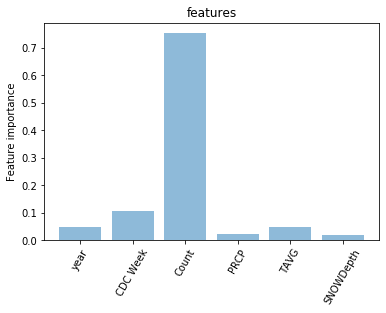

In [17]:
feature_importance = model_dt.feature_importances_
feature_importance_sorted = (np.sort(feature_importance))[::-1]
print("feature_importance = ", feature_importance)

y_pos = np.arange(len(features))
plt.bar(y_pos,feature_importance, align='center', alpha=0.5)
plt.xticks(y_pos, X_train.columns[:len(features)])
plt.ylabel('Feature importance')
plt.title('features')
plt.xticks(rotation=60)

plt.show()

Selecting best min sample leaf values and min sample split values for decision trees

In [20]:
min_samples_split_values = [int(i) for i in np.logspace(1, 12, num=10, base=2)]
min_samples_leaf_values = [int(i) for i in np.logspace(1, 12, num=10, base=2)]

def testTrees(x_train, x_test, y_train, y_test, split, leaf):
    '''
    Build a function that takes in tree hyperparams, data and returns accuracy on test data
    '''
    model = tree.DecisionTreeRegressor(criterion='mse',min_samples_leaf = leaf, min_samples_split = split)
    
    model.fit(x_train,y_train)
    test_p = model.predict(x_test)
    train_p = model.predict(x_train)
    
    test_r2_score = metrics.r2_score(y_test, test_p)
    train_r2_score = metrics.r2_score(y_train, train_p)

    return train_r2_score, test_r2_score
 
res = dict()
train_res = dict()
for s in min_samples_leaf_values:
    res[s] = list()
    train_res[s] = list()

for l in min_samples_leaf_values:
    for s in min_samples_split_values:
        train_r2_score, test_r2_score = testTrees(X_train_scaled, X_test_scaled, y_train, y_test, s, l)
        res[s].append(test_r2_score)
        train_res[s].append(train_r2_score)

#To get the best test score
maximum = max(res, key=res.get)
#print(maximum, res[maximum])
print("min sample leaf value = {}, sample split value = {} for the best R2 score = {}" .format(s ,res[maximum].index(max(res[maximum])) , max(res[maximum]) * 100))

min sample leaf value = 4096, sample split value = 2 for the best R2 score = 73.35156512608198


In [21]:
#To get train value corresponding to best test result
print("Train R2 score corresponding to best test result = " ,train_res[maximum][res[maximum].index(max(res[maximum]))] * 100)

Train R2 score corresponding to best test result =  83.8834980067892


Text(0.5, 1.0, 'Holdout Accuracy by Hyperparameters')

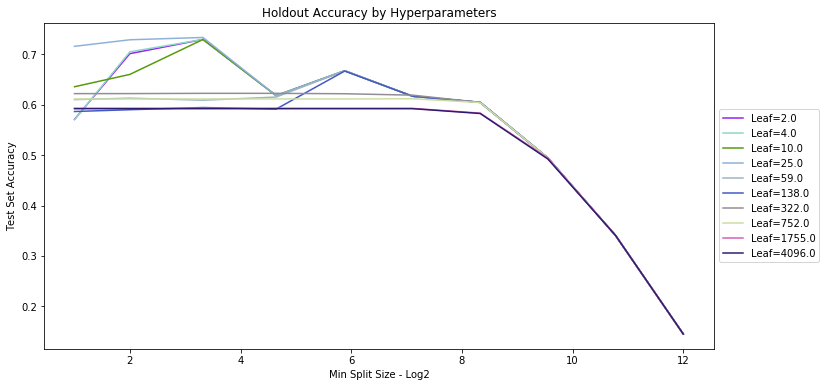

In [22]:
def r():
    return np.random.rand()

fig = plt.figure(figsize = (15, 6))
ax = fig.add_subplot(111)

for l in min_samples_leaf_values:
    plt.plot(np.log2(min_samples_split_values), res[l], 
             color=(r(),r(),r()), label='Leaf={}'.format(np.floor(l)))

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Min Split Size - Log2')
ax.set_ylabel('Test Set Accuracy')
plt.title('Holdout Accuracy by Hyperparameters')

In [23]:
model_rf = ensemble.RandomForestRegressor(n_estimators = 500)
model_rf.fit(X_train_scaled, y_train)
y_train_pred_randomForest = model_rf.predict(X_test_scaled)
Test_r2_score_randomForest = metrics.r2_score(y_test, y_train_pred_randomForest)
print("R2 Score for Random Forest on testing data = {}" .format(Test_r2_score_randomForest * 100))

y_train_pred_randomForest = model_rf.predict(X_train_scaled)
Train_r2_score_randomForest = metrics.r2_score(y_train, y_train_pred_randomForest)
print("R2 Score for Random Forest on training data = {}" .format(Train_r2_score_randomForest * 100))

R2 Score for Random Forest on testing data = 76.12781697829908
R2 Score for Random Forest on training data = 98.05453202434904


K fold Cross Validation

In [24]:
n_splits = 5
tscv = model_selection.TimeSeriesSplit(n_splits=n_splits)
split_number = 0
best_r2 = 0
r2_score_cv = []
for train_index, test_index in tscv.split(X):
  split_number += 1
  #print("TRAIN:", train_index, "TEST:", test_index)
  X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
  y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

  mm_scaler = sklearn.preprocessing.MinMaxScaler()
  X_train_cv_scaled = mm_scaler.fit_transform(X_train_cv)
  X_test_cv_scaled = mm_scaler.transform(X_test_cv)

  model_rf = sklearn.ensemble.RandomForestRegressor(n_estimators = 500)
  model_rf.fit(X_train_cv_scaled, y_train_cv)
  y_train_pred_randomForest = model_rf.predict(X_test_cv_scaled)
  Test_r2_score_randomForest = metrics.r2_score(y_test_cv, y_train_pred_randomForest)
  print("R2 Score for Random Forest on testing data = {} for split number = {}" .format(Test_r2_score_randomForest * 100, split_number))

  y_train_pred_randomForest = model_rf.predict(X_train_cv_scaled)
  Train_r2_score_randomForest = metrics.r2_score(y_train_cv, y_train_pred_randomForest)
  print("R2 Score for Random Forest on training data = {} for split number = {}" .format(Train_r2_score_randomForest * 100, split_number))

  r2_score_cv.append(Test_r2_score_randomForest)

  if Test_r2_score_randomForest > best_r2:
    best_r2 = Test_r2_score_randomForest
    best_split_model = copy.deepcopy(model_rf)
    best_split_X_train = X_train_cv.copy()
    best_split_X_test = y_train_cv.copy()

print("R2 Score for the best Random Forest model on testing data = {}" .format(best_r2 * 100))

R2 Score for Random Forest on testing data = 66.8704165097468 for split number = 1
R2 Score for Random Forest on training data = 95.15814509746684 for split number = 1
R2 Score for Random Forest on testing data = 63.3102468222633 for split number = 2
R2 Score for Random Forest on training data = 95.91523671806218 for split number = 2
R2 Score for Random Forest on testing data = 72.91044537760847 for split number = 3
R2 Score for Random Forest on training data = 97.34171077800089 for split number = 3
R2 Score for Random Forest on testing data = 88.13055003402131 for split number = 4
R2 Score for Random Forest on training data = 97.54192062759614 for split number = 4
R2 Score for Random Forest on testing data = 75.96392821387109 for split number = 5
R2 Score for Random Forest on training data = 98.10626844107304 for split number = 5
R2 Score for the best Random Forest model on testing data = 88.13055003402131


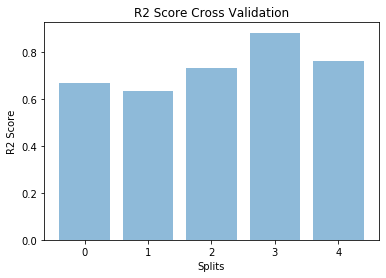

In [25]:
y_pos = np.arange(n_splits)
plt.bar(y_pos,r2_score_cv, align='center', alpha=0.5)
plt.xticks(y_pos,range(n_splits))
plt.ylabel('R2 Score')
plt.xlabel('Splits')
plt.title('R2 Score Cross Validation')

plt.show()